In [55]:
import glob
import os
from collections import Counter
from itertools import combinations, product

import numpy as np
np.random.seed(18012023)

import pandas as pd
pd.set_option('display.max_colwidth', 0)

from sklearn.metrics import pairwise_distances
import lxml.etree
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from IPython.display import display

## Loading and preprocessing

In [56]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,date,provenance,date_range,genre,subgenre,exclude
204,Lutgard K,Sinte Lutgard,NaN,1267.5,CG1,1270-1265,Epiek,Heiligenleven,NaN
63,florigout_fragm_l,Florigout,NaN,1387.5,cdrom-mnl,1375-1400,Epiek,Ridder,NaN
111,loyhier_en_malaert_fragm_a,Loyhier en Malaert,NaN,1375.0,cdrom-mnl,1350-1400,Epiek,Karel,NaN
86,historie_van_gaver_capeel,Historie van Gaver Capeel,NaN,1510.0,cdrom-mnl,1500-1520,Epiek,Ridder,NaN
235,spiegel_historiael__4_velthem__fragm_l,Spiegel historiael (P4 [Velthem]),Lodewijk van Velthem,1350.0,cdrom-mnl,1340-1360,Epiek,Historiografie,NaN
153,ongeidentificeerd_6,Ongeïdentificeerd (6),NaN,1387.5,cdrom-mnl,1375-1400,Epiek,Karel,NaN
211,spiegel_der_sonden,Spiegel der sonden,NaN,1450.0,cdrom-mnl,1440-1460,Epiek,Didactiek,NaN
123,madelgijs_fragm_p,Madelgijs,NaN,1387.5,cdrom-mnl,1375-1400,Epiek,Karel,NaN
167,Reinout van Montalbaen,Reinout van Montalbaen,NaN,1288.0,CG1,1300-1276,Epiek,Karel,NaN
241,tien_plaghen,Tien plaghen ende die tien ghebode,NaN,1400.0,cdrom-mnl,1390-1410,Epiek,Didactiek,NaN


In [57]:
def get_verse_groups(verses, size=2, intertexts=False):
    for i in range(len(verses) - (size)):
        if not intertexts:
            yield ' / '.join(verses[i : i + size])
        else:
            its = Counter(verses[i : i + size])
            if None in its:
                yield None
            elif len(its) > 1:
                yield 'overlap'
            else:
                yield list(its.keys())[0]

In [58]:
GROUP_SIZE = 2

titles, tokens, lemmas, intertexts = [], [], [], []

for title, group in tqdm(meta_df.groupby('title')):
    work_tokens, work_lemmas, work_intertexts = [], [], []
    
    for id_ in sorted(group['id']):
        try:
            tree = lxml.etree.parse(f'../data/xml/{id_}.xml')
        except OSError:
            print(f'- Could not load {id_}')
            continue
        
        # don't remove interpolations?
        #for interpolation in tree.xpath("//interpolation"):
        #    interpolation.getparent().remove(interpolation)
        
        for line_node in tree.iterfind('//l'):
            try:
                intertext_id = line_node.attrib['intertext']
            except KeyError:
                intertext_id = None
            
            tokens_ = line_node.attrib['tokens'].split()
            lemmas_ = []
            
            lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
            pos_tags = [p.text for p in line_node.iterfind('.//pos')]
            
            for lemma, pos in zip(lemma_tags, pos_tags):
                for l, p in zip(lemma.split('+'), pos.split('+')):
                        if p == 'n(prop)':
                            lemmas_.append('n(prop)')
                        else:
                            lemmas_.append(l)
        
            work_tokens.append(tokens_)
            work_lemmas.append(lemmas_)
            work_intertexts.append(intertext_id)
    
    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))
    verse_group_intertexts = list(get_verse_groups(work_intertexts, size=GROUP_SIZE, intertexts=True))

    tokens.extend(verse_group_tokens)
    lemmas.extend(verse_group_lemmas)
    intertexts.extend(verse_group_intertexts)
    titles.extend([title] * len(verse_group_lemmas))

100%|██████████| 206/206 [00:39<00:00,  5.18it/s]


In [59]:
df = pd.DataFrame(zip(titles, tokens, lemmas, intertexts), columns=('title', 'tokens', 'lemmas', 'intertext'))
df = df[df['intertext'] != 'overlap']
df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

,title,tokens,lemmas,intertext
350351,Karel ende Elegast,Crone draghen ende houden hof / Om te meerderen sinen lof,kroon dragen en houden hof / om te meerderen zijn lof,mor-ele-2
350387,Karel ende Elegast,Als die seere was vereent / Wat ist dat dit wonder meent,als de zeer zijn verenen / wat het zijn dat dit wonder menen,lan-ele-47
350399,Karel ende Elegast,Mijn lant is so groot / Men vint nyewers sijns ghenoot,mijn land zijn zo groot / men vinden nieuwer zijn genoot,mor-ele-5
350438,Karel ende Elegast,En wil ic niet laten achter / Ic sel dief wesen al ist lachter,ne willen ik niet laten achter / ik zullen dief wezen al zijn het lachter,mor-ele-8
350466,Karel ende Elegast,Moet varen in een lant / Dat mi is vremde ende onbecant,moeten varen in een land / dat ik zijn vreemd en onbekend,mor-ele-10
350468,Karel ende Elegast,Mit deser talen ghinc hem gereyden / Die coninc karel ende cleyden,met deze taal gaan hij gereden / de koning n(prop) en kleden,mor-ele-11
350541,Karel ende Elegast,Dieue te hatene daer icse wiste / Die den lieden mit liste,dief te haten daar ik zij weten / die de lieden met list,mor-ele-15
350565,Karel ende Elegast,Beide borch ende lant / Des was ic herde onbekant,beide burg en land / dat zijn ik harden onbekend,mor-ele-16
350631,Karel ende Elegast,Nochtan weet ic te voren wel / Tis die duuel ende niemant el,nochtan weten ik te voren wel / het is de duivel en niemand el,mor-ele-17
350645,Karel ende Elegast,Pensde hi in sinen sin / Dese is verdoelt hier in,peinzen hij in zijn zin / deze zijn verdolen hier in,mor-ele-19


In [60]:
vec = TfidfVectorizer(max_features=10000, min_df=2, token_pattern=r"(?u)\b\w+\b")
X = vec.fit_transform(df['lemmas'])
X.shape

(924823, 10000)

In [61]:
rhyme_words = []
for lemmas in df['lemmas']:
    rhymes = []
    for verse in lemmas.split(' / '):
        rhymes.append(verse.strip().split()[-1])
    rhyme_words.append(' '.join(rhymes))
df['rhyme'] = rhyme_words

df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

,title,tokens,lemmas,intertext,rhyme
350351,Karel ende Elegast,Crone draghen ende houden hof / Om te meerderen sinen lof,kroon dragen en houden hof / om te meerderen zijn lof,mor-ele-2,hof lof
350387,Karel ende Elegast,Als die seere was vereent / Wat ist dat dit wonder meent,als de zeer zijn verenen / wat het zijn dat dit wonder menen,lan-ele-47,verenen menen
350399,Karel ende Elegast,Mijn lant is so groot / Men vint nyewers sijns ghenoot,mijn land zijn zo groot / men vinden nieuwer zijn genoot,mor-ele-5,groot genoot
350438,Karel ende Elegast,En wil ic niet laten achter / Ic sel dief wesen al ist lachter,ne willen ik niet laten achter / ik zullen dief wezen al zijn het lachter,mor-ele-8,achter lachter
350466,Karel ende Elegast,Moet varen in een lant / Dat mi is vremde ende onbecant,moeten varen in een land / dat ik zijn vreemd en onbekend,mor-ele-10,land onbekend
350468,Karel ende Elegast,Mit deser talen ghinc hem gereyden / Die coninc karel ende cleyden,met deze taal gaan hij gereden / de koning n(prop) en kleden,mor-ele-11,gereden kleden
350541,Karel ende Elegast,Dieue te hatene daer icse wiste / Die den lieden mit liste,dief te haten daar ik zij weten / die de lieden met list,mor-ele-15,weten list
350565,Karel ende Elegast,Beide borch ende lant / Des was ic herde onbekant,beide burg en land / dat zijn ik harden onbekend,mor-ele-16,land onbekend
350631,Karel ende Elegast,Nochtan weet ic te voren wel / Tis die duuel ende niemant el,nochtan weten ik te voren wel / het is de duivel en niemand el,mor-ele-17,wel el
350645,Karel ende Elegast,Pensde hi in sinen sin / Dese is verdoelt hier in,peinzen hij in zijn zin / deze zijn verdolen hier in,mor-ele-19,zin in


## Nearest neighbors

In [62]:
def nearest_verses(title1, title2, base_df, vectorizer, prop_filt=2, rhyme_weight=.25):
    A = base_df[base_df['title'] == title1]
    B = base_df[base_df['title'] == title2]
    
    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    
    nearest = []
    for i, ax in enumerate(AX):
        distances = pairwise_distances(ax, BX, metric='cosine').flatten()
        top_i = distances.argsort()[0]
        nearest.append((A.iloc[i]['tokens'], B.iloc[top_i]['tokens'],
                        A.iloc[i]['lemmas'], B.iloc[top_i]['lemmas'],
                        A.iloc[i]['title'], B.iloc[top_i]['title'],
                        A.iloc[i]['intertext'], B.iloc[top_i]['intertext'],
                        distances[top_i]))

    nearest = pd.DataFrame(nearest,
                           columns=['tokens1', 'tokens2', 'lemmas1', 'lemmas2',
                                    'title1', 'title2', 'intertext1', 'intertext2',
                                    'distance'])

    nearest = nearest[nearest['title1'] != nearest['title2']]
    nearest = nearest[
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) & \
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) 
                     ]
    return nearest

In [63]:
nearest_df = nearest_verses('Moriaen', 'Karel ende Elegast',
                            base_df=df, vectorizer=vec, prop_filt=2)
nearest_df = nearest_df.sort_values(by='distance')
nearest_df.head(50)

,tokens1,tokens2,lemmas1,lemmas2,title1,title2,intertext1,intertext2,distance
163,Nu es leden die derde dach / Dat ic voer om min bejach,Dies is leden die derde dach / Dat ic voer om mijn beiach,nu zijn lijden de derde dag / dat ik varen om mijn bejag,die zijn lijden de derde dag / dat ik varen om mijn bejag,Moriaen,Karel ende Elegast,mor-ele-44,mor-ele-44,0.032437
2909,Ende segt mi ende maect mi vroet / Wat noetsaken dat u doet,In dien dat ghi mi maket vroet / Wat nootsaken dat v doet,en zeggen ik en maken ik vroed / wat noodzaak dat gij doen,in die dat gij ik maken vroed / wat noodzaak dat uw doen,Moriaen,Karel ende Elegast,mor-ele-31,mor-ele-31,0.113156
193,Want ic come u te genaden / Van allen minen mesdaden,Ic come v heden te ghenaden / Van allen minen misdaden,want ik komen gij te genade / van al mijn misdaad,ik komen gij heden te genade / van al mijn misdaad,Moriaen,Karel ende Elegast,mor-ele-72,mor-ele-72,0.119965
1288,Men doet mi lachter onverdient / Quame enech Gods vrient,Dadi mi lachter onuerdient / Ghi hadt verloren menigen vrient,men doen ik lachter onverdiend / komen enig god vriend,doen ik lachter onverdiend / gij hebben verliezen menig vriend,Moriaen,Karel ende Elegast,None,None,0.180574
1839,Die grote ondaet ende die mort / Hi sprac te sinen lieden vort,Dat ghi segt ende brenct voort / Die ondaet ende die moort,de groot ondaad en de moord / hij spreken te zijn lieden voort,dat gij zeggen en brengen voort / de ondaad en de moord,Moriaen,Karel ende Elegast,mor-ele-70,mor-ele-70,0.184378
447,Dan mi een ridder dwingen soude / Van dies ic doen nine woude,Dat mi een man dwinghen soude / Van dinghen die ic niet en woude,dan ik een ridder dwingen zullen / van die ik doen ne niet willen,dat ik een man dwingen zullen / van ding die ik niet ne willen,Moriaen,Karel ende Elegast,mor-ele-22,mor-ele-22,0.195125
893,U ne gesciets niet te wors / Her Walewein sat doe op sijn ors,Al souts mi sijn te wors / Nv sit weder op v ors,gij ne geschieden niet te waars / heer n(prop) zitten toen op zijn hors,al zullen ik zijn te waars / nu zitten weer op uw hors,Moriaen,Karel ende Elegast,mor-ele-78,mor-ele-78,0.204850
877,Maer wistic uwer beider name / Ende u wille ware ende bequame,Ick sel v segghen minen name / Ist v wille ende bequame,maar ik weten uw beide naam / en uw wil zijn en bekwaam,ik zullen gij zeggen mijn naam / zijn het uw wil en bekwaam,Moriaen,Karel ende Elegast,mor-ele-38,mor-ele-38,0.205585
2949,Si hadden daer soe grote macht / Ende vingen Arture met harre cracht,Eggeric was van groter macht / Ende alle die hadden cracht,zij hebben daar zo groot macht / en vangen n(prop) met haar kracht,n(prop) zijn van groot macht / en al die hebben kracht,Moriaen,Karel ende Elegast,None,None,0.229380
3763,Doe pensdi in sinen moet / Op dattie trappen waren so goet,Pensde hi in sinen moet / Dat ick leue waer toe ist goet,toen hij peinzen in zijn moed / op dat de n(prop) zijn zo goed,peinzen hij in zijn moed / dat ik leven zijn toe zijn het goed,Moriaen,Karel ende Elegast,None,None,0.233530


## Top-K

Limitation: assumes that you know the source quote!

In [64]:
meta = pd.read_excel('../data/intertexts.xlsx')
meta

,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks,Unnamed: 8
0,mor-ele-1,Moriaen,Dat magic v nv tellen,Karel ende Elegast,Mach ic v tellen,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
1,mor-ele-2,Moriaen,hilt hof Om te merre sinen lof.,Karel ende Elegast,houden hof Omme te meerne sinen lof:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
2,mor-ele-3,Moriaen,Hastelike ende nine spard.,Karel ende Elegast,Haestelic ende niet en spaert:,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
3,mor-ele-4,Moriaen,Nv nes niweren in ertrike.,Karel ende Elegast,En es man in aertrijcke:,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
4,mor-ele-5,Moriaen,sine macht (es) so groet Ic waen men nigeren sine genoet Ne soude vinden.,Karel ende Elegast,Mijns selfs lant es soe groot Men vint nyewers sijns ghenoot:,3,"Heeroma 1973a, Moriaen (I)",NaN,NaN
...,...,...,...,...,...,...,...,...,...
224,mor-ele-40,Lantsloot van der Haghedochte,Ende droegen des ouer een:,Moriaen,Ende drogen des daer ouer een.,1,NaN,Nestedness!,NaN
225,mor-ele-61,Lantsloot van der Haghedochte,Dien hi harde lange voer Ende vernam van niemene boer:,Moriaen,Daer men met scepen ouer voer Ende daer verlosic al dat boer.,2,NaN,NaN,NaN
226,lan-ele-74,Lantsloot van der Haghedochte,Ende sijn ors toe gemake gedaen:,Moriaen,Sijn ors was te gemake gedaen.,1,NaN,NaN,NaN
227,lan-ele-75,Lantsloot van der Haghedochte,Doe die dienst was gedaen:,Moriaen,Doe die dinst was gedaen.,1,NaN,NaN,NaN


In [65]:
def top_k(title1, title2, base_df, meta, vectorizer,
          length_threshold=2, rhyme_weight= 0.5, k=10):
    meta = meta[meta['verse-length'] >= length_threshold]
    meta = meta[(meta['source'] == title1) | (meta['source'] == title2)]
    meta = meta[(meta['target'] == title1) | (meta['target'] == title2)]
    
    if not len(meta):
        return None
    
    A = base_df[(base_df['title'] == title1) & (base_df['intertext'].isin(meta['ID']))]
    B = base_df[base_df['title'] == title2]
    
    AX = vectorizer.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vectorizer.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    
    hits_in_k, results, retrieved = 0, [], []
    
    for (_, a), ax in zip(A.iterrows(), AX):
        distances = pairwise_distances(ax, BX, metric='cosine').flatten()
        top_k = distances.argsort()[:k]
        candidates = B.iloc[top_k].copy()
        candidates['distance'] = distances[top_k]
        candidates['category'] = 'hit'
        
        if a['intertext'] in set(candidates['intertext']):
            hits_in_k += 1
            retrieved.append(True)
        else:
            retrieved.append(False)

        a['distance'] = 0.0
        a['category'] = 'query'
        
        candidates.loc[len(candidates)] = a
        results.append(candidates.sort_values('distance'))

    return {'num_hits': hits_in_k,
            'num_queries': len(A),
            'coverage': hits_in_k / len(A),
            'retrieval': retrieved,
            'ranking': results}

In [66]:
results = top_k('Moriaen', 'Lantsloot van der Haghedochte', df, meta, vec,
                length_threshold=2, rhyme_weight= 0.5, k=3)

for r, res in zip(results['retrieval'], results['ranking']):
    if r:
        display(res)

,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Ende daer die hoge liede saten / Over die tafle ende aten,en daar de hoog lieden zitten / over de tafel en eten,lan-ele-4,zitten eten,0.000000,query
393336,Lantsloot van der Haghedochte,Teersten dattie coninc sat / Ouer taflen ende hi at,eerst het dat de koning zitten / over tafel en hij eten,lan-ele-4,zitten eten,0.169990,hit
397292,Lantsloot van der Haghedochte,Daer die ridders waren gheseten / Ter taflen ende hadden begonnen eten,daar de ridder zijn zitten / de te tafel en hebben beginnen eten,None,zitten eten,0.201242,hit
397302,Lantsloot van der Haghedochte,Die hier ter taflen sijn gheseten / Om drinken ende om eten,die hier de te tafel zijn zitten / om drinken en om eten,None,zitten eten,0.273114,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Over die tafle ende aten / Quam een riddere in gereden,over de tafel en eten / komen een ridder in rijden,lan-ele-4,eten rijden,0.000000,query
393337,Lantsloot van der Haghedochte,Ouer taflen ende hi at / Quam i ridder in gheuaren,over tafel en hij eten / komen 1 ridder in varen,lan-ele-4,eten varen,0.349666,hit
393336,Lantsloot van der Haghedochte,Teersten dattie coninc sat / Ouer taflen ende hi at,eerst het dat de koning zitten / over tafel en hij eten,lan-ele-4,zitten eten,0.448638,hit
397292,Lantsloot van der Haghedochte,Daer die ridders waren gheseten / Ter taflen ende hadden begonnen eten,daar de ridder zijn zitten / de te tafel en hebben beginnen eten,None,zitten eten,0.450014,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Dat en mochte niet bederven / Noch van genen wonden sterven,dat ne mogen niet bederven / noch van geen wond sterven,mor-ele-74,bederven sterven,0.000000,query
393935,Lantsloot van der Haghedochte,Dat hi noch bedorue / Ende van sinen wonden storue,dat hij nog bederven / en van zijn wond sterven,mor-ele-74,bederven sterven,0.151427,hit
392791,Lantsloot van der Haghedochte,Dat die hertoghe starf / Tintageel ende bedarf,dat de hertog sterven / tentegel en bederven,None,sterven bederven,0.227141,hit
396940,Lantsloot van der Haghedochte,Diene mach in campe niet steruen / No in watre bederuen,die hij mogen in kamp niet sterven / no in water bederven,mor-ele-74,sterven bederven,0.295793,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Ende begonste drinken ende eten / Ende sijns leets vele vergeten,en beginnen drinken en eten / en zijn leed veel vergeten,mor-mou-2,eten vergeten,0.000000,query
397326,Lantsloot van der Haghedochte,Ghinghen si drinken ende eten / Ende hars leets vergheten,gaan zij drinken en eten / en haar leed vergeten,mor-mou-2,eten vergeten,0.112935,hit
397723,Lantsloot van der Haghedochte,Dat men drinken mocht ende eten / Ende leets bi vergheten,dat men drinken mogen en eten / en leed bij vergeten,lan-ele-62,eten vergeten,0.123635,hit
398405,Lantsloot van der Haghedochte,Men rechte taflen ende ghinc eten / Die ridder was scire vergeten,men recht tafel en gaan eten / die ridder zijn schier vergeten,None,eten vergeten,0.353002,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Tirst dattie dinst was gedaen / Quam die coninc Artur gegaen,eerst het dat de dienst zijn doen / komen de koning n(prop) gaan,mor-mou-3,doen gaan,0.000000,query
397126,Lantsloot van der Haghedochte,Alse die dienst was ghedaen / Ende die nacht an ghegaen,als de dienst zijn doen / en de nacht aan gaan,mor-mou-3,doen gaan,0.269091,hit
397260,Lantsloot van der Haghedochte,Die niet ne was ridder ghedaen / Jnt ander paulioen gegaen,die niet ne zijn ridder doen / in dat ander paulonium gaan,None,doen gaan,0.440021,hit
397048,Lantsloot van der Haghedochte,Ende sijn ghebet ghedaen / Hi soude ten etene sitten gaen,en zijn gebed doen / hij zullen te de eten zitten gaan,None,doen gaan,0.480657,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Doe moestic varen achter lande / Ic moets lien al eest scande,toen ik moeten varen achter land / ik moeten lijden al het zijn schande,mor-ele-33,land schande,0.000000,query
395987,Lantsloot van der Haghedochte,Ende here ware van minen lande / Jc salt segghen al ist scande,en heer zijn van mijn land / ik het zullen zeggen al het zijn schande,mor-ele-33,land schande,0.301522,hit
395988,Lantsloot van der Haghedochte,Jc salt segghen al ist scande / Ende ic moeste sijn gheselle sijn,ik het zullen zeggen al het zijn schande / en ik moeten zijn gezel zijn,None,schande zijn,0.348677,hit
397087,Lantsloot van der Haghedochte,Ende voerne vten lande / Gheuiele ons dat het ware scande,en voeren uit de land / gevallen wij dat het zijn schande,None,land schande,0.398771,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Alsickere mochte geriden / Ende langer niet ontbiden,als mogen gerijden / en lang niet ontbieden,lan-ele-43,gerijden ontbieden,0.000000,query
398410,Lantsloot van der Haghedochte,Ende langer niet onbiden / Ende doedinele met hem leiden,en lang niet ontbieden / en n(prop) met hij leiden,None,ontbieden leiden,0.592516,hit
396393,Lantsloot van der Haghedochte,Ende langher niet onbiden / Dur gheens mans bede,en lang niet ontbieden / door geen man beide,None,ontbieden beide,0.593352,hit
396392,Lantsloot van der Haghedochte,Sprac lantsloot ic wil riden / Ende langher niet onbiden,spreken n(prop) ik willen rijden / en lang niet ontbieden,lan-ele-43,rijden ontbieden,0.596832,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Nu ne licgic nembermee / Boven enen nacht of twee,nu ne ik liggen nimmermee / boven een nacht of twee,lan-ele-38,nimmermee twee,0.000000,query
396009,Lantsloot van der Haghedochte,Dat hine laghe nemmermee / Bouen ere nacht ofte twee,dat hij hij liggen nimmermee / boven een nacht of twee,lan-ele-38,nimmermee twee,0.061045,hit
396008,Lantsloot van der Haghedochte,Ende galioot in diren eden suoer / Dat hine laghe nemmermee,en n(prop) in duur eed zweren / dat hij hij liggen nimmermee,None,zweren nimmermee,0.511190,hit
396010,Lantsloot van der Haghedochte,Bouen ere nacht ofte twee / Vor hi horde rechte niemare,boven een nacht of twee / voor hij horen recht nieuwmaar,None,twee nieuwmaar,0.585354,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Nu manic u bi aldien / Die ridderscaeps nu plien,nu ik manen gij bij al die / de ridderschap nu plegen,mor-ele-69,die plegen,0.000000,query
394629,Lantsloot van der Haghedochte,Bi ridderscepe ende bi al dien / Dat goet man soude plien,bij ridderschap en bij al die / dat goed man zullen plegen,None,die plegen,0.273835,hit
397903,Lantsloot van der Haghedochte,Die bloeme was van al dien / Die ridderscaps plien,de bloem zijn van al die / de ridderschap plegen,mor-ele-69,die plegen,0.303739,hit
393025,Lantsloot van der Haghedochte,Har scone sone lantsloot / Nv moghedi horen wat si plach,haar schoon zoon n(prop) / nu gij mogen horen wat zij plegen,None,n(prop) plegen,0.498688,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Dat haer verstarf van haren vader / Het es ons ontwijst algader,dat zij versterven van haar vader / het zijn wij ontwijzen algader,lan-ele-14,vader algader,0.000000,query
395115,Lantsloot van der Haghedochte,Ende warder of sijn man algader / Dats hem verstarf van sinen vader,en worden of zijn man algader / dat het hij versterven van zijn vader,None,algader vader,0.209939,hit
394117,Lantsloot van der Haghedochte,Hi verlore eer sijn goet algader / Dat hem verstarf van sinen vader,hij verliezen eer zijn goed algader / dat hij versterven van zijn vader,lan-ele-14,algader vader,0.242087,hit
392865,Lantsloot van der Haghedochte,Doe wijsdijt hare algader / Te doene slapen haren vader,toen het wij wijzen zij algader / te doen slapen haar vader,None,algader vader,0.332256,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Die de coninc beide begeert / Ende sinen sin daer ombe verteert,die de koning beide begeren / en zijn zin daar om verteren,lan-ele-66,begeren verteren,0.000000,query
397993,Lantsloot van der Haghedochte,Ende die v sere begheren / Dat si haren sin verteren,en die gij zeer begeren / dat zij haar zijn verteren,lan-ele-66,begeren verteren,0.210484,hit
397330,Lantsloot van der Haghedochte,Dat hi der ioncfrouwen iet begherde / Die doch haren sin verterde,dat hij de jonkvrouw iets begeren / die doch haar zijn verteren,None,begeren verteren,0.280927,hit
395590,Lantsloot van der Haghedochte,Hine hadde ghenoech des hi begherde / Ende dat hi daghelics verterde,hij ne hebben genoeg dat hij begeren / en dat hij dagelijks verteren,None,begeren verteren,0.319975,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Ende sinen sin daer ombe verteert / Om hen te sprekene ende te sine,en zijn zin daar om verteren / om zij te spreken en te zijn,lan-ele-66,verteren zijn,0.000000,query
397994,Lantsloot van der Haghedochte,Dat si haren sin verteren / Om v te sprekene ende te siene,dat zij haar zijn verteren / om gij te spreken en te zien,lan-ele-66,verteren zien,0.201054,hit
394962,Lantsloot van der Haghedochte,Daer hi so omme verterde / Sine herte ende sijn lijf,daar hij zo om verteren / zijn hart en zijn lijf,None,verteren lijf,0.305318,hit
396550,Lantsloot van der Haghedochte,Of si den ridder souden verteren / Ende hi began hem sere weren,of zij de ridder zullen verteren / en hij beginnen hij zeer zijn,None,verteren zijn,0.353911,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Om hen te sprekene ende te sine / Mochtewi bi enegen engiene,om zij te spreken en te zijn / mogen wij bij enig engien,lan-ele-66,zijn engien,0.000000,query
397995,Lantsloot van der Haghedochte,Om v te sprekene ende te siene / Mochten si v vinden bi engiene,om gij te spreken en te zien / mogen zij gij vinden bij engien,lan-ele-66,zien engien,0.198354,hit
396855,Lantsloot van der Haghedochte,Om te horne ende te siene / Om eneghe niewe te sciene,om te horen en te zien / om enig nieuw te schijnen,None,zien schijnen,0.762313,hit
395391,Lantsloot van der Haghedochte,Siere hulpen ne staet ons niet tonberne / Ende dede ghebieden achter there,zijn hulp ne staan wij niet ontberen te / en doen gebieden achter een te,None,te te,0.780852,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Ende wi uwen vader bringen / Wille ons God dies gehingen,en wij uw vader brengen / wil wij god die gehengen,lan-ele-67,brengen gehengen,0.000000,query
394721,Lantsloot van der Haghedochte,Mach sie se wech bringhen / Ende mens hare wil gehingen,mogen zij zij weg brengen / en men het haar wil gehengen,None,brengen gehengen,0.267017,hit
397997,Lantsloot van der Haghedochte,Ende binnen haren lande bringhen / Ents hem god wilde ghehinghen,en binnen hun land brengen / en hij god willen gehengen,lan-ele-67,brengen gehengen,0.277679,hit
394235,Lantsloot van der Haghedochte,Sine mochten mj niet wech bringen / Want inne wildes niet gehingen,ne zij mogen ik niet weg brengen / want ik ne willen niet gehengen,None,brengen gehengen,0.366581,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Echt leide di swerte sine hande te gader / Ende seide God onser alre vader,echt leggen de zwart zijn hand te gader / en zeggen god ons al vader,lan-ele-60,gader vader,0.000000,query
397620,Lantsloot van der Haghedochte,Hi leide beide hande te gader / Ende seide dur gode onsen vader,hij leggen beide hand te gader / en zeggen door god ons vader,lan-ele-60,gader vader,0.168620,hit
393128,Lantsloot van der Haghedochte,Leide si doe har hande te gader / Te gode wart onsen vader,leggen zij toen haar hand te gader / te n(prop) worden ons vader,None,gader vader,0.218231,hit
396663,Lantsloot van der Haghedochte,Orconde hem alle gader / Doe quam meliagants uader,oorkonde hij al gader / toen komen n(prop) vader,None,gader vader,0.365198,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Die es der werelt toeverlaet / Die late mi noch mine mesdaet,die zijn de wereld toeverlaat / die laten ik nog mijn misdaad,lan-ele-52,toeverlaat misdaad,0.000000,query
397308,Lantsloot van der Haghedochte,Die es der warelt toeuerlaet / Die late mj mine mesdaet,die zijn de wereld toeverlaat / die laten ik mijn misdaad,lan-ele-52,toeverlaat misdaad,0.029363,hit
393931,Lantsloot van der Haghedochte,Si es der werelt toeuerlaet / Ende mach verdingen onse mesdaet,zij zijn de wereld toeverlaat / en mogen verdingen ons misdaad,None,toeverlaat misdaad,0.219582,hit
397307,Lantsloot van der Haghedochte,God ende sijn moeder beide / Die es der warelt toeuerlaet,god en zijn moeder beide / die zijn de wereld toeverlaat,None,beide toeverlaat,0.407328,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Die late mi noch mine mesdaet / Gebeteren noch tuwer ere,die laten ik nog mijn misdaad / gebeteren noch te uw eer,lan-ele-52,misdaad eer,0.000000,query
397309,Lantsloot van der Haghedochte,Die late mj mine mesdaet / So ghebetren tuwer ere,die laten ik mijn misdaad / zo gebeteren toe eer,lan-ele-52,misdaad eer,0.121903,hit
393819,Lantsloot van der Haghedochte,Berouwet hem sine misdaet / Eer die ziele vten lichame gaet,berouwen hij zijn misdaad / eer de ziel de uit lichaam gaan,None,misdaad gaan,0.513208,hit
398112,Lantsloot van der Haghedochte,Ende betert vwe mesdaden / Die ander sprac hi sloech te doot,en beteren uw misdaad / de ander spreken hij slaan te dood,None,misdaad dood,0.531762,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Gebeteren noch tuwer ere / Her Lanceloet wel live here,gebeteren noch te uw eer / heer n(prop) wel lijf heer,lan-ele-52,eer heer,0.000000,query
397310,Lantsloot van der Haghedochte,So ghebetren tuwer ere / Lieue ridder lieue here,zo gebeteren toe eer / lief ridder lief heer,lan-ele-52,eer heer,0.299802,hit
397979,Lantsloot van der Haghedochte,Ende si seide god lone v here / Ende behoude v in vwe ere,en zij zeggen god lonen uw heer / en behouden gij in uw eer,None,heer eer,0.411355,hit
398571,Lantsloot van der Haghedochte,Ende ontfinghene wel met eren / Dus waren te samene daer die heren,en hij ontvangen wel met eer / dus zijn te samen daar de heer,None,eer heer,0.413490,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Doe worden die heren in dole / Ende si ontstaken als een cole,toen worden de heer in dool / en zij ontsteken als een kool,lan-ele-25,dool kool,0.000000,query
395018,Lantsloot van der Haghedochte,Hier omme ben ic in dole / Ende berne als ene cole,hier om zijn ik in dool / en branden als een kool,lan-ele-25,dool kool,0.183505,hit
395019,Lantsloot van der Haghedochte,Ende berne als ene cole / Toter wilen dat ic weet,en branden als een kool / tot de wijl dat ik weten,lan-ele-25,kool weten,0.499200,hit
393992,Lantsloot van der Haghedochte,Bernen moetic al te colen / Sprac van rostoc die vrouwe,branden ik moeten al te kool / spreken van n(prop) de vrouw,None,kool vrouw,0.539471,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Ende si ontstaken als een cole / Van rouwen dat si nine wisten,en zij ontsteken als een kool / van rouw dat zij ne niet weten,lan-ele-25,kool weten,0.000000,query
395019,Lantsloot van der Haghedochte,Ende berne als ene cole / Toter wilen dat ic weet,en branden als een kool / tot de wijl dat ik weten,lan-ele-25,kool weten,0.282895,hit
393992,Lantsloot van der Haghedochte,Bernen moetic al te colen / Sprac van rostoc die vrouwe,branden ik moeten al te kool / spreken van n(prop) de vrouw,None,kool vrouw,0.453449,hit
395018,Lantsloot van der Haghedochte,Hier omme ben ic in dole / Ende berne als ene cole,hier om zijn ik in dool / en branden als een kool,lan-ele-25,dool kool,0.507157,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Nu kiest voren live here / Welke strate gi wilt riden,nu kiezen voren lijf heer / welk straat gij willen rijden,mor-ele-12,heer rijden,0.000000,query
397135,Lantsloot van der Haghedochte,Ende dede hem wapinen ende ghereden / Alse die wech wilde riden,en doen hij wapen en rijden / als de weg willen rijden,None,rijden rijden,0.461151,hit
396688,Lantsloot van der Haghedochte,Alse hi sach dat si met goede / Harre straten wilden riden,als hij zien dat zij met goed / haar straat willen rijden,None,goed rijden,0.469521,hit
396120,Lantsloot van der Haghedochte,Ende elc vercoos ene strate / Darwart dat si wilden riden,en elk verkos een straat / daarwaart dat zij willen rijden,mor-ele-12,straat rijden,0.499619,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Welke strate gi wilt riden / Hier nes geen langer biden,welk straat gij willen rijden / hier ne zijn geen lang bij de,mor-ele-12,rijden de,0.000000,query
396121,Lantsloot van der Haghedochte,Darwart dat si wilden riden / Met hem liden was gheen biden,daarwaart dat zij willen rijden / met hij lijden zijn geen bij de,mor-ele-12,rijden de,0.361217,hit
397135,Lantsloot van der Haghedochte,Ende dede hem wapinen ende ghereden / Alse die wech wilde riden,en doen hij wapen en rijden / als de weg willen rijden,None,rijden rijden,0.384789,hit
396688,Lantsloot van der Haghedochte,Alse hi sach dat si met goede / Harre straten wilden riden,als hij zien dat zij met goed / haar straat willen rijden,None,goed rijden,0.412900,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Maer dat was pine jegen spoet / Al haddemen hem gegeven alt goet,maar dat zijn pijn jegen spoed / al hebben men hij geven al dat goed,mor-ele-49,spoed goed,0.000000,query
396905,Lantsloot van der Haghedochte,Mar dat was pine ieghen spoet / Die hare ghegheuen hadde alt goet,maar dat zijn pijn jegen spoed / die zij geven hebben al dat goed,mor-ele-49,spoed goed,0.046183,hit
396904,Lantsloot van der Haghedochte,Ende seide hebt goet verdrach / Mar dat was pine ieghen spoet,en zeggen hebben goed verdrag / maar dat zijn pijn jegen spoed,None,verdrag spoed,0.346829,hit
397216,Lantsloot van der Haghedochte,Mar dat was pine ieghen spoet / Hare verwandelde so har moet,maar dat zijn pijn jegen spoed / zij verwandelen zo haar moeten,None,spoed moeten,0.364140,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Al haddemen hem gegeven alt goet / Datten coninc Arture toe horde,al hebben men hij geven al dat goed / dat hij koning n(prop) toe horen,mor-ele-49,goed horen,0.000000,query
396906,Lantsloot van der Haghedochte,Die hare ghegheuen hadde alt goet / Daer artur of was here,die zij geven hebben al dat goed / daar n(prop) af zijn heer,mor-ele-49,goed heer,0.495387,hit
395204,Lantsloot van der Haghedochte,Des moghedi die wareit horen / Ende alse die goede lieden,dat n(prop) de waarheid horen / en als de goed lieden,None,horen lieden,0.532659,hit
396351,Lantsloot van der Haghedochte,Van hem daer gi of hebt gehort / Ende kere weder te lantslote,van hij daar gij of hebben horen / en keren weder te n(prop),None,horen n(prop),0.555816,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Wi mochten sceden wel so verre / Dat wijs mochten werden erre,wij mogen scheiden wel zo ver / dat wij het mogen worden erre,lan-ele-58,ver erre,0.000000,query
397569,Lantsloot van der Haghedochte,Jn dat wout so verre / Dats sulke sider worden erre,in dat woud zo ver / dat zijn zulk sedert worden erre,lan-ele-58,ver erre,0.305961,hit
393176,Lantsloot van der Haghedochte,Hi es sinen vianden verre / Ghine durftes niet sijn erre,hij zijn zijn vijand ver / gij ne durven niet zijn erre,None,ver erre,0.360147,hit
396321,Lantsloot van der Haghedochte,Daer gi mj mede maket erre / Dat kenlijc wort al den lande,daar gij ik mede maken erre / dat kenlijk worden al dat land,None,erre land,0.544904,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Si was groet ende oec diep / Ende dat water sere te dale liep,zij zijn groot en ook diep / en dat water zeer te dal lopen,lan-ele-51,diep lopen,0.000000,query
397156,Lantsloot van der Haghedochte,Op ene riuiere breet ende diep / Ende daer twater sere of liep,op een rivier breed en diep / en daar het water zeer of lopen,lan-ele-51,diep lopen,0.251521,hit
398035,Lantsloot van der Haghedochte,Die wijt was ende diep / Entie harde sere liep,die wijd zijn en diep / die en harde zeer lopen,None,diep lopen,0.266921,hit
396480,Lantsloot van der Haghedochte,Ouer die riuiere diere liep / Harde donker ende diep,over de rivier die er lopen / harde donker en diep,None,lopen diep,0.366582,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Ende dat water sere te dale liep / Crachtelike ende die stroem,en dat water zeer te dal lopen / krachtelijk en de stroom,lan-ele-51,lopen stroom,0.000000,query
397157,Lantsloot van der Haghedochte,Ende daer twater sere of liep / Te dale waert entie stroom,en daar het water zeer of lopen / te dal waart de en stroom,lan-ele-51,lopen stroom,0.130973,hit
397158,Lantsloot van der Haghedochte,Te dale waert entie stroom / Daer sach lantsloot ende nam goom,te dal waart de en stroom / daar zien n(prop) en nemen n(prop),lan-ele-51,stroom n(prop),0.361524,hit
393532,Lantsloot van der Haghedochte,In dat water datter liep / Ende daer sie an gode omme riep,in dat water dat er lopen / en daar zij aan god om roepen,None,lopen roepen,0.651729,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Crachtelike ende die stroem / Daer mercte Walewein ende nam goem,krachtelijk en de stroom / daar merken n(prop) en nemen goom,lan-ele-51,stroom goom,0.000000,query
397158,Lantsloot van der Haghedochte,Te dale waert entie stroom / Daer sach lantsloot ende nam goom,te dal waart de en stroom / daar zien n(prop) en nemen n(prop),lan-ele-51,stroom n(prop),0.386122,hit
397281,Lantsloot van der Haghedochte,Hi nam der heren groten goom / Ende hi dede lambeguse gheuen,hij nemen de heer groot goom / en hij doen n(prop) geven,None,goom geven,0.507051,hit
397157,Lantsloot van der Haghedochte,Ende daer twater sere of liep / Te dale waert entie stroom,en daar het water zeer of lopen / te dal waart de en stroom,lan-ele-51,lopen stroom,0.511779,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Hoe een riddere quam gereden / Op een ors van sconen leden,hoe een ridder komen rijden / op een hors van n(prop) lid,lan-ele-68,rijden lid,0.000000,query
398167,Lantsloot van der Haghedochte,Dats dat i ridder quam ghereden / Op i ors met sconen leden,dat zijn dat een ridder komen rijden / op 1 hors met schoon lid,lan-ele-68,rijden lid,0.157796,hit
397252,Lantsloot van der Haghedochte,Dystorie seghet dat quam ghereden / Op i ors met sconen leden,de zeggen dat komen rijden / op 1 hors met schoon lid,None,rijden lid,0.224016,hit
395467,Lantsloot van der Haghedochte,Daer ic verliese lijf ende lede / Mar of gi emmer wilt riden,daar ik verliezen lijf en lid / maar of gij immer willen rijden,None,lid rijden,0.386484,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Sach hi volc bi groten scaren / Naden riddere comen gevaren,zien hij volk bij groot schare / de na ridder komen varen,mor-ele-65,schare varen,0.000000,query
393208,Lantsloot van der Haghedochte,Liede bi groten scaren / In die middelt quam gheuaren,lieden bij groot schare / in de n(prop) komen varen,mor-ele-65,schare varen,0.199299,hit
398535,Lantsloot van der Haghedochte,Brinct hi binnen siere scaren / xx ridders die comen geuaren,brengen hij binnen zijn schare / 20 ridder die komen varen,None,schare varen,0.286389,hit
396711,Lantsloot van der Haghedochte,Ende voeren wech tere scaren / Diere quamen ende diere waren,en varen weg een te schare / die komen en die er zijn,None,schare zijn,0.390885,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Si quamen te samen met selker porse / Dattie riddere viel vanden orsse,zij komen te samen met zulk pers / dat de ridder vallen de van hors,lan-ele-59,pers hors,0.000000,query
397577,Lantsloot van der Haghedochte,Ende om haelden hare orse / Si quamen te samen met sulker porse,en om halen haar hors / zij komen te samen met zulk pers,None,hors pers,0.138974,hit
397578,Lantsloot van der Haghedochte,Si quamen te samen met sulker porse / Dat die ridder tumelde ter erde,zij komen te samen met zulk pers / dat de ridder toemelden te de aarde,lan-ele-59,pers aarde,0.264714,hit
397576,Lantsloot van der Haghedochte,Ende sagremor greep tsine / Ende om haelden hare orse,en n(prop) grijpen de zijn / en om halen haar hors,None,zijn hors,0.638885,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Ende viel soe sere dat hem deerde / In alle die lede toter herten,en vallen zo zeer dat hij aarde / in al de lid tot de hart,lan-ele-59,aarde hart,0.000000,query
397815,Lantsloot van der Haghedochte,Vallen moeste optie erde / Van der steke die hem so derde,vallen moeten op de aarde / van de steek die hij zo aarde,None,aarde aarde,0.412159,hit
394859,Lantsloot van der Haghedochte,Dattet siere herten derde / Doe die ander lach ter erde,dat het zijn hart derde / toen de ander liggen de te aarde,None,derde aarde,0.511269,hit
397580,Lantsloot van der Haghedochte,Ende vel so sere dat hem derde / Ter herte ende an al die lede,en vel zo zeer dat hij derde / de te hart en aan al de lid,lan-ele-59,derde lid,0.532678,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Binnen desen was becomen / Die riddere ende hadde sijn sward genomen,binnen deze zijn bekomen / de ridder en hebben zijn zwart nemen,lan-ele-63,bekomen nemen,0.000000,query
397789,Lantsloot van der Haghedochte,Binnen dien was die ander becomen / Ende hadde sijn swerd ghenomen,binnen die zijn de ander bekomen / en hebben zijn zwaard nemen,lan-ele-63,bekomen nemen,0.187433,hit
395730,Lantsloot van der Haghedochte,Doe die hertoge was becomen / Van der pinen die hi hadde genomen,toen de hertog zijn bekomen / van de pijn die hij hebben nemen,None,bekomen nemen,0.275293,hit
394891,Lantsloot van der Haghedochte,Te lantslote dien hi op nam / Ende lantsloot bequam,te n(prop) die hij op nemen / en n(prop) bekomen,None,nemen bekomen,0.286934,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Oft gi ember vechten wilt / Hi decte hem onder sinen scilt,of gij immer vechten willen / hij dekken hij onder zijn schild,lan-ele-10,willen schild,0.000000,query
393717,Lantsloot van der Haghedochte,Alse die ghene die vechten wilden / Si deckeden hem met haren scilden,als de gene die vechten willen / zij dekken hij met haar schild,lan-ele-10,willen schild,0.217027,hit
397797,Lantsloot van der Haghedochte,Den andren in sinen scilde / Dat hi wilde of ne wilde,de ander in zijn schild / dat hij willen of ne willen,None,schild willen,0.284957,hit
397813,Lantsloot van der Haghedochte,Vor die borst metten scilde / Dat hi wilde of ne wilde,voor de borst met de schild / dat hij willen of ne willen,None,schild willen,0.344165,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Ende Walewein der aventuren vader / Versagetse soe daer allegader,en n(prop) de avontuur vader / verzeggen zij zo daar algader,lan-ele-76,vader algader,0.000000,query
398579,Lantsloot van der Haghedochte,Entie ridders allegader / Badens der auenturen vader,de en ridder algader / bode de avontuur vader,lan-ele-76,algader vader,0.258231,hit
394151,Lantsloot van der Haghedochte,Van deser dinc algader / Bi gode onsen rechten vader,van deze ding algader / bij n(prop) ons recht vader,None,algader vader,0.355049,hit
397446,Lantsloot van der Haghedochte,Sie seiden ia si allegader / Mar omme dat gi waert sijn vader,zij zeggen ja zij algader / maar om dat gij zijn zijn vader,None,algader vader,0.362064,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,So lange voer hi dat hi sach / Dattet dien avonde naecte,zo lang varen hij dat hij zien / dat het de avond naken,lan-ele-50,zien naken,0.000000,query
397153,Lantsloot van der Haghedochte,Des hi die sonne nederen sach / Ent den auonde nakede,dat hij de zon nederen zien / en de avond naken,lan-ele-50,zien naken,0.227025,hit
396134,Lantsloot van der Haghedochte,Dattet nakede ten auonde / Ende hi sach menech wilt dier,dat het naken te de avond / en hij zien menig willen die,None,avond die,0.301620,hit
396133,Lantsloot van der Haghedochte,Voer hi wech toter stonde / Dattet nakede ten auonde,varen hij weg tot de stond / dat het naken te de avond,None,stond avond,0.390715,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Dattet dien avonde naecte / Binnen dien Walewein geraecte,dat het de avond naken / binnen de n(prop) geraken,lan-ele-50,naken geraken,0.000000,query
397154,Lantsloot van der Haghedochte,Ent den auonde nakede / Binnen dien lantsloot gherakede,en de avond naken / binnen de landsloot geraken,lan-ele-50,naken geraken,0.125139,hit
397153,Lantsloot van der Haghedochte,Des hi die sonne nederen sach / Ent den auonde nakede,dat hij de zon nederen zien / en de avond naken,lan-ele-50,zien naken,0.422840,hit
396134,Lantsloot van der Haghedochte,Dattet nakede ten auonde / Ende hi sach menech wilt dier,dat het naken te de avond / en hij zien menig willen die,None,avond die,0.439522,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Die begert te wesene min gast / Hi heeft geleide goet ende vast,die begeren te wezen mijn gast / hij hebben geleide goed en vast,lan-ele-3,gast vast,0.000000,query
393312,Lantsloot van der Haghedochte,Dat hi des nachts ware sijn gast / In enen casteel goet ende vast,dat hij de nacht zijn zijn gast / in een kasteel goed en vast,lan-ele-3,gast vast,0.289540,hit
398577,Lantsloot van der Haghedochte,Bat die here sinen gast / Met goeder herten harde vast,bidden de heer zijn gast / met goed hart harde vast,None,gast vast,0.300272,hit
398539,Lantsloot van der Haghedochte,Sprac die ghene ic bens vast / Doe vragede walewein har gast,spreken de gene ik zijn vast / toen vragen n(prop) haar gast,None,vast gast,0.338643,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Dat ic minne vor alle dien / Die nu ridderscaps mogen plien,dat ik minnen voor al die / die nu ridderschap mogen plegen,mor-ele-69,die plegen,0.000000,query
397903,Lantsloot van der Haghedochte,Die bloeme was van al dien / Die ridderscaps plien,de bloem zijn van al die / de ridderschap plegen,mor-ele-69,die plegen,0.250559,hit
394629,Lantsloot van der Haghedochte,Bi ridderscepe ende bi al dien / Dat goet man soude plien,bij ridderschap en bij al die / dat goed man zullen plegen,None,die plegen,0.278023,hit
397904,Lantsloot van der Haghedochte,Die ridderscaps plien / Met rechte claghe ic mine scade,de ridderschap plegen / met recht klaag ik mijn schade,None,plegen schade,0.510735,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Dies die eerde nie gedroech / Des men drinken mochte ende eten,dat de aarde nieuw gedragen / dat men drinken mogen en eten,lan-ele-62,gedragen eten,0.000000,query
397722,Lantsloot van der Haghedochte,Van des men vant bouen den erde / Dat men drinken mocht ende eten,van de men vinden boven de aarde / dat men drinken mogen en eten,lan-ele-62,aarde eten,0.409101,hit
397723,Lantsloot van der Haghedochte,Dat men drinken mocht ende eten / Ende leets bi vergheten,dat men drinken mogen en eten / en leed bij vergeten,lan-ele-62,eten vergeten,0.572227,hit
397302,Lantsloot van der Haghedochte,Die hier ter taflen sijn gheseten / Om drinken ende om eten,die hier de te tafel zijn zitten / om drinken en om eten,None,zitten eten,0.643714,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Des men drinken mochte ende eten / Ende alles leets daer bi vergeten,dat men drinken mogen en eten / en al leed daar bij vergeten,lan-ele-62,eten vergeten,0.000000,query
397723,Lantsloot van der Haghedochte,Dat men drinken mocht ende eten / Ende leets bi vergheten,dat men drinken mogen en eten / en leed bij vergeten,lan-ele-62,eten vergeten,0.018825,hit
397326,Lantsloot van der Haghedochte,Ghinghen si drinken ende eten / Ende hars leets vergheten,gaan zij drinken en eten / en haar leed vergeten,mor-mou-2,eten vergeten,0.120283,hit
398405,Lantsloot van der Haghedochte,Men rechte taflen ende ghinc eten / Die ridder was scire vergeten,men recht tafel en gaan eten / die ridder zijn schier vergeten,None,eten vergeten,0.334025,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Ende drogen des over een / Die daer waren in den steen,en dragen de over een / die daar zijn in de steen,mor-ele-40,een steen,0.000000,query
394479,Lantsloot van der Haghedochte,Si hebben gedreghen ouer een / Die daer sijn in den steen,zij hebben dragen over een / die daar zijn in de steen,mor-ele-40,een steen,0.040053,hit
394480,Lantsloot van der Haghedochte,Die daer sijn in den steen / Dat menne sal voeren in yrlant,die daar zijn in de steen / dat hij men zullen varen in n(prop),None,steen n(prop),0.342834,hit
397478,Lantsloot van der Haghedochte,Ten castele van den iiij stenen / Daer vant die coninc sijn kint,te de kasteel van de 4 steen / daar vinden de koning zijn kind,None,steen kind,0.484864,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Al hadde die riddere wel verdient / Der doet hi hadde daer menegen vrient,al hebben de ridder wel verdienen / de dood hij hebben daar menig vriend,lan-ele-56,verdienen vriend,0.000000,query
397511,Lantsloot van der Haghedochte,Mar al hadde hi der doot verdient / Hi hadde nochtan meneghen vrient,maar al hebben hij de dood verdienen / hij hebben nochtan menig vriend,lan-ele-56,verdienen vriend,0.114178,hit
394825,Lantsloot van der Haghedochte,Dat lantsloot hadde des verdient / Dat Galioot was so wel sijn vrient,dat n(prop) hebben dat verdienen / dat n(prop) zijn zo wel zijn vriend,None,verdienen vriend,0.251464,hit
393853,Lantsloot van der Haghedochte,Dat hi hemelrike verdient / Het doet goet wesen gods vrient,dat hij hemelrijk verdienen / het doen goed wezen god vriend,None,verdienen vriend,0.324180,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Der doet hi hadde daer menegen vrient / Die sere clageden haren toren,de dood hij hebben daar menig vriend / die zeer klagen haar toorn,lan-ele-56,vriend toorn,0.000000,query
397512,Lantsloot van der Haghedochte,Hi hadde nochtan meneghen vrient / Die sere clagheden haren toren,hij hebben nochtan menig vriend / die zeer klagen haar toorn,lan-ele-56,vriend toorn,0.076673,hit
397513,Lantsloot van der Haghedochte,Die sere clagheden haren toren / Ende sijn vader al te voren,die zeer klagen haar toorn / en zijn vader al te voren,None,toorn voren,0.403564,hit
397908,Lantsloot van der Haghedochte,Alle die met har waren / Om harre vrouwen toren,al die met haar zijn / om haar vrouw toorn,None,zijn toorn,0.439562,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Daer waren ridders ende seriande / Naest den here vanden lande,daar zijn ridder en sergeant / naast de heer van het land,lan-ele-46,sergeant land,0.000000,query
396731,Lantsloot van der Haghedochte,Die behorden te sinen lande / Beide ridders ende seriande,die behoren te zijn land / beide ridder en sergeant,lan-ele-46,land sergeant,0.229047,hit
395091,Lantsloot van der Haghedochte,Na dien hertoge quam i seriant / Die brochte dat scermeghewant,na de hertog komen 1 sergeant / die brengen dat schermschinten,None,sergeant schermschinten,0.427841,hit
395090,Lantsloot van der Haghedochte,Ende waren alle blide / Na dien hertoge quam i seriant,en zijn al blij / na de hertog komen 1 sergeant,None,blij sergeant,0.491799,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Toter wilen datmen sach / Verbaren den sconen dach,de tot wijl dat men zien / verbaren de schoon dag,lan-ele-53,zien dag,0.000000,query
397336,Lantsloot van der Haghedochte,Totes morghens dat men sach / Verbaren den sconen dach,tot de morgen dat men zien / verbaren de schoon dag,lan-ele-53,zien dag,0.114498,hit
394798,Lantsloot van der Haghedochte,Des morghens alsemen sach / Verbaren den sconen dach,de morgen als men zien / verbaren de schoon dag,None,zien dag,0.166341,hit
397337,Lantsloot van der Haghedochte,Verbaren den sconen dach / Doene wilde hi langher letten niet,verbaren de schoon dag / doen willen hij lang letten niet,None,dag niet,0.433164,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Jagen des hi gerne plach / Binnen enen groten foreeste,n(prop) des hij gaarne plegen / binnen een groot foreest,lan-ele-8,plegen foreest,0.000000,query
397500,Lantsloot van der Haghedochte,In een lant hiet sauage / Dat stont binnen enen foreeste,in een land heten n(prop) / dat staan binnen een foreest,None,n(prop) foreest,0.379897,hit
393473,Lantsloot van der Haghedochte,Metten ghenen die daer waren / Jaghen in dat foreest,met de geen die daar zijn / jagen in dat foreest,lan-ele-8,zijn foreest,0.481593,hit
397501,Lantsloot van der Haghedochte,Dat stont binnen enen foreeste / Dat alre wideste dat alre meeste,dat staan binnen een foreest / dat al weden dat al meest,lan-ele-55,foreest meest,0.494029,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Binnen enen groten foreeste / Daer quam in ene die meeste,binnen een groot foreest / daar komen in een de meest,lan-ele-8,foreest meest,0.000000,query
397501,Lantsloot van der Haghedochte,Dat stont binnen enen foreeste / Dat alre wideste dat alre meeste,dat staan binnen een foreest / dat al weden dat al meest,lan-ele-55,foreest meest,0.169434,hit
396153,Lantsloot van der Haghedochte,Voer hi bet vort bi enen foreeste / Daer hi horde dat alre meeste,voor hij bet voorts bij een foreest / daar hij horen dat al meest,None,foreest meest,0.244559,hit
393474,Lantsloot van der Haghedochte,Jaghen in dat foreest / Dar hi bewaende wildes meest,jagen in dat foreest / daar hij bewanen willen meest,lan-ele-8,foreest meest,0.276084,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Binnen also corter wile / Alse te ridene ene mile,binnen alzo kort wijl / als te rijden een mijl,lan-ele-16,wijl mijl,0.000000,query
396422,Lantsloot van der Haghedochte,Alse hi hadde ghereden ene wile / Binnen den woude ene halue mile,als hij hebben rijden een wijl / binnen de woud een half mijl,None,wijl mijl,0.181750,hit
397288,Lantsloot van der Haghedochte,Dus saten si ene wile / Datmen riden mochte ene mile,dus zitten zij een wijl / dat men rijden mogen een mijl,None,wijl mijl,0.215594,hit
394521,Lantsloot van der Haghedochte,Ende ouer ene corte wile / Datmen mochte ene halue mile,en over een kort wijl / dat men mogen een half mijl,lan-ele-16,wijl mijl,0.221729,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,In coerre vore gene have / Al vondic man dise mi gave,in kor voor geen have / al ik vinden man die zij ik geven,mor-ele-35,have geven,0.000000,query
397999,Lantsloot van der Haghedochte,Daer uore namen si ghene haue / Al vonden si man die se hem gaue,daar voor nemen zij geen have / al vinden zij man die zij hij geven,mor-ele-35,have geven,0.220025,hit
393989,Lantsloot van der Haghedochte,Of ickene hier liete om enige haue / Al vondic man die se mj gaue,of hij ik hier laten om enig have / al ik vinden man die zij ik geven,mor-ele-35,have geven,0.266130,hit
393681,Lantsloot van der Haghedochte,Ende seide dat hi hem niet ne gaue / Een penewart van siere haue,en zeggen dat hij hij niet ne geven / een pennewaart van zijn have,None,geven have,0.375157,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Dus sciden si onder hen tween / Ende Gariet reet al in een,dus scheiden zij onder zij twee / en n(prop) rijden al in een,mor-ele-79,twee een,0.000000,query
395628,Lantsloot van der Haghedochte,Doe scieden si onder hem tween / Die hertoge voer al in een,toen scheiden zij onder hij twee / de hertog voor al in een,mor-ele-79,twee een,0.211458,hit
394179,Lantsloot van der Haghedochte,Dat wi dus droegen ouer een / Ic ende sie onder ons tween,dat wij dus dragen over een / ik en zij onder wij twee,mor-ele-40,een twee,0.308462,hit
395352,Lantsloot van der Haghedochte,Si troesten se sere onder hem tween / Elc sonderlinghe al in een,zij troosten zij zeer onder hij twee / elk zonderling al in een,None,twee een,0.323107,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Van al datmen volbringen mochte / Al leidicker an mine gedochte,van al dat men volbrengen mogen / al leidik aan mijn gedachte,lan-ele-26,mogen gedachte,0.000000,query
396091,Lantsloot van der Haghedochte,Dan ic v wel vertellen mochte / Al leidicker an mijn gedochte,dan ik gij wel vertellen mogen / al leidik aan mijn gedachte,lan-ele-26,mogen gedachte,0.250934,hit
395085,Lantsloot van der Haghedochte,Bet dan ic gheseggen mochte / Al leidicker an mijn ghedochte,bet dan ik gezeggen mogen / al leidik aan mijn gedachte,None,mogen gedachte,0.275182,hit
397019,Lantsloot van der Haghedochte,Weder hi mochte of ne mochte / Mar om dat har hars ghedochte,weder hij mogen of ne mogen / maar om dat zij haar gedachte,None,mogen gedachte,0.337535,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Alse hoge alse ene kerke / Ende van harden diren gewerke,als hoog als een kerk / en van hard dier gewerk,lan-ele-20,kerk gewerk,0.000000,query
394755,Lantsloot van der Haghedochte,Die was van hoghen gewerke / Alst ware ene kerke,die zijn van hoog gewerk / als het zijn een kerk,lan-ele-20,gewerk kerk,0.136720,hit
393925,Lantsloot van der Haghedochte,Het es die bloeme daer die kerke / Bi es gheleert ende scone gewerke,het zijn de bloem daar de kerk / bij zijn leren en schoon gewerk,None,kerk gewerk,0.338462,hit
394754,Lantsloot van der Haghedochte,Si ghinc tere venstern voren / Die was van hoghen gewerke,zij gaan een te venster voren / die zijn van hoog gewerk,None,voren gewerk,0.466037,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Ende min broder heeft hem begeven / Om te beterne sijn leven,en mijn broeder hebben hij begeven / om te beteren zijn leven,lan-mor-2,begeven leven,0.000000,query
397901,Lantsloot van der Haghedochte,Die doot dat si mj laet leuen / Ende hi des lijfs heft begheuen,de dood dat zij ik laten leven / en hij de lijf hebben begeven,None,leven begeven,0.306850,hit
392986,Lantsloot van der Haghedochte,Die in den closter waren begheuen / Ende leiden i swaer leuen,die in de klooster zijn begeven / en leiden een zwaar leven,None,begeven leven,0.358302,hit
393008,Lantsloot van der Haghedochte,Datter die vrowen waren begheuen / Ende leiden een salich leuen,dat er de vrouw zijn begeven / en leiden een zalig leven,lan-mor-2,begeven leven,0.360702,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Ende wapine goet ter cure / Si porden ute ter goder ure,en wapen goed te de keur / zij poort uit de te goed uur,lan-ele-44,keur uur,0.000000,query
396579,Lantsloot van der Haghedochte,Jc sal uechten op dese ure / Hi was ghewapint wel te cure,ik zullen vechten op deze uur / hij zijn gewapend wel te keur,lan-ele-44,uur keur,0.333241,hit
392980,Lantsloot van der Haghedochte,Ende bediede altoos in goeden / Hier latic staen te deser vre,en beduiden altoos in goed / hier ik laten staan te deze uur,None,goed uur,0.499357,hit
393421,Lantsloot van der Haghedochte,Hi sat op sijn ors saen / Hi was ghereden wel ter cure,hij zitten op zijn hors zaan / hij zijn rijden wel de te keur,None,zaan keur,0.559783,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Doen en werd daer geen langer sparen / Sine gereiden hare vart,doen ne worden daar geen lang sparen / hij gereden haar vaart,lan-ele-30,sparen vaart,0.000000,query
395409,Lantsloot van der Haghedochte,Doene was daer gheen langer sparen / Hi dede sine liede ghereiden,doen zijn daar geen lang sparen / hij doen zijn lieden gereden,lan-ele-30,sparen gereden,0.279053,hit
398480,Lantsloot van der Haghedochte,Hine haddes daghes niet ghespaert / Die lanc was ende heet,hij ne hebben het dag niet sparen / die lang zijn en heten,None,sparen heten,0.509373,hit
395408,Lantsloot van der Haghedochte,Om die hem waren ontfaren / Doene was daer gheen langer sparen,om die hij zijn ontvaren / doen zijn daar geen lang sparen,None,ontvaren sparen,0.516166,hit


,title,tokens,lemmas,intertext,rhyme,distance,category
3,Moriaen,Want daer was goets genoech / Elc hadde daer wel sijn gevoech,want daar zijn goed genoeg / elk hebben daar wel zijn gevoeg,lan-ele-32,genoeg gevoeg,0.000000,query
395474,Lantsloot van der Haghedochte,Doe seide die hertoge dats mj ghenoech / Ende wel mijn gheuoech,toen zeggen de hertog dat zijn ik genoeg / en wel mijn gevoeg,lan-ele-32,genoeg gevoeg,0.232773,hit
397204,Lantsloot van der Haghedochte,Hi vanter haets ende drancs ghenoech / Dat was wel sijn gheuoech,hij en vinden haat en drank genoeg / dat zijn wel zijn gevoeg,None,genoeg gevoeg,0.279677,hit
397985,Lantsloot van der Haghedochte,An v es te prisene ghenoech / Beide doghet ende gheuoech,aan gij zijn te prijzen genoeg / beide deugd en gevoeg,None,genoeg gevoeg,0.292773,hit


#### Vary $k$

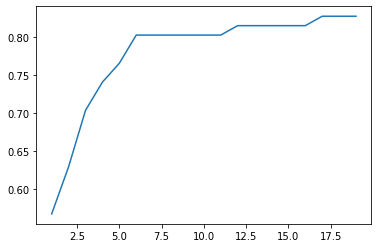

In [67]:
Ks = range(1, 20)
scores = [top_k('Moriaen', 'Lantsloot van der Haghedochte', df, meta, vec,
                length_threshold=2, rhyme_weight= 0.5, k=i)['coverage'] for i in Ks]
plt.plot(Ks, scores);

Directionality effect!

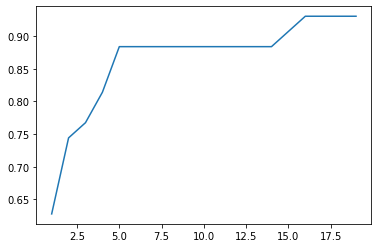

In [68]:
scores = [top_k('Karel ende Elegast', 'Moriaen', df, meta, vec,
                length_threshold=2, rhyme_weight= 0.5, k=i)['coverage'] for i in Ks]
plt.plot(Ks, scores);

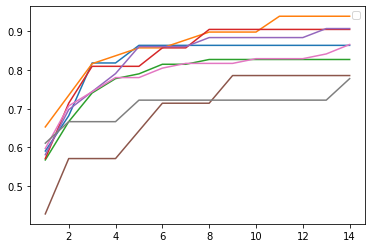

In [69]:
titles = set(list(meta['source']) + list(meta['target']))
scores = []

Ks = range(1, 15)

for t1 in titles:
    for t2 in titles:
        if t1 != t2:
            sc = []
            for i in Ks:
                r = top_k(t1, t2, df, meta, vec,
                        length_threshold=2, rhyme_weight=0.25, k=i)
                if r:
                    sc.append(r['coverage'])
            if sc:
                scores.append(sc)
    
scores = pd.DataFrame(np.array(scores).T, index=Ks)
scores.plot(legend=False)
plt.legend([]);

#### Vary rhyme weight

In [70]:
scores = []
thresholds = np.linspace(0, 2, 30)

for t1 in titles:
    for t2 in titles:
        if t1 != t2:
            print(t1, t2)
            sc = []
            for th in thresholds:
                r = top_k(t1, t2, df, meta, vec,
                        length_threshold=2, rhyme_weight=th, k=5)
                if r:
                    sc.append(r['coverage'])
            if sc:
                scores.append(sc)
    
scores = pd.DataFrame(np.array(scores).T, index=thresholds)

Moriaen Riddere metter mouwen
Moriaen Karel ende Elegast
Moriaen Lantsloot van der Haghedochte
Riddere metter mouwen Moriaen
Riddere metter mouwen Karel ende Elegast
Riddere metter mouwen Lantsloot van der Haghedochte
Karel ende Elegast Moriaen
Karel ende Elegast Riddere metter mouwen
Karel ende Elegast Lantsloot van der Haghedochte
Lantsloot van der Haghedochte Moriaen
Lantsloot van der Haghedochte Riddere metter mouwen
Lantsloot van der Haghedochte Karel ende Elegast


<AxesSubplot:>

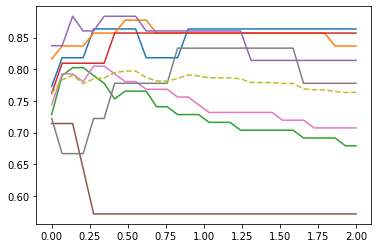

In [71]:
ax = scores.plot(legend=False)
scores.mean(axis=1).plot(ax=ax, label='mean', ls='--')

Optimal rhyme weight?

In [73]:
theta = scores.index[scores.mean(axis=1).argmax()]
theta

0.48275862068965514

## Vary actual distance

In [74]:
def top_dist(title1, title2, base_df, meta, vectorizer,
          length_threshold=2, rhyme_weight=theta, dist_threshold=10):
    meta = meta[meta['verse-length'] >= length_threshold]
    meta = meta[(meta['source'] == title1) | (meta['source'] == title2)]
    meta = meta[(meta['target'] == title1) | (meta['target'] == title2)]
    
    if not len(meta):
        return None
    
    A = base_df[(base_df['title'] == title1) & (base_df['intertext'].isin(meta['ID']))]
    B = base_df[base_df['title'] == title2]
    
    AX = vectorizer.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vectorizer.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    
    hits_in_k, results, retrieved = 0, [], []
    
    for (_, a), ax in zip(A.iterrows(), AX):
        distances = pairwise_distances(ax, BX, metric='cosine').flatten()
        top_k = distances <= dist_threshold
        candidates = B.iloc[top_k].copy()
        candidates['distance'] = distances[top_k]
        candidates['category'] = 'hit'
        
        if a['intertext'] in set(candidates['intertext']):
            hits_in_k += 1
            retrieved.append(True)
        else:
            retrieved.append(False)

        a['distance'] = 0.0
        a['category'] = 'query'
        
        candidates.loc[len(candidates)] = a
        results.append(candidates.sort_values('distance'))

    return {'num_hits': hits_in_k,
            'num_queries': len(A),
            'coverage': hits_in_k / len(A),
            'retrieval': retrieved,
            'ranking': results}

In [ ]:
scores = []
thresholds = np.linspace(.1, .75, 20)

for t1 in titles:
    for t2 in titles:
        if t1 != t2:
            print(t1, t2)
            sc = []
            for th in thresholds:
                r = top_dist(t1, t2, df, meta, vec,
                        length_threshold=2, rhyme_weight=theta, dist_threshold=th)
                if r:
                    sc.append(r['coverage'])
            if sc:
                scores.append(sc)
    
scores = pd.DataFrame(np.array(scores).T, index=thresholds)

Moriaen Riddere metter mouwen
Moriaen Karel ende Elegast
Moriaen Lantsloot van der Haghedochte
Riddere metter mouwen Moriaen


In [ ]:
ax = scores.plot(legend=False)
scores.mean(axis=1).plot(ax=ax, label='mean', ls='--');

## Distribution in distances

In [53]:
same_distances, diff_distances = [], []

for t1, t2 in combinations(titles, 2):
    if t1 == t2:
        continue

    m = meta[meta['verse-length'] >= 2]
    m = m[(m['source'] == t1) | (m['source'] == t2)]
    m = m[(m['target'] == t1) | (m['target'] == t2)]
            
    if not len(m):
        continue
    
    As = df[(df['intertext'].isin(m['ID'])) & (df['title'] == t1)]
    Bs = df[(df['intertext'].isin(m['ID'])) & (df['title'] == t2)]
    
    AX = vec.transform(As['lemmas']) + theta * vec.transform(As['rhyme'])
    BX = vec.transform(Bs['lemmas']) + theta * vec.transform(Bs['rhyme'])
    #RX = vec.transform(rnd_Bs['lemmas']) + theta * vec.transform(rnd_Bs['rhyme'])
    
    same_distances.extend(pairwise_distances(AX, BX, metric='cosine').flatten())
    #diff_distances.extend(pairwise_distances(AX, RX, metric='cosine').flatten())

/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


ValueError: zero-size array to reduction operation fmax which has no identity

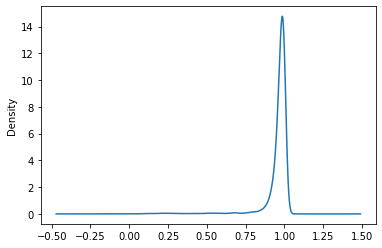

In [54]:
ss = pd.Series(same_distances)
ds = pd.Series(diff_distances)

ax = ss.plot.kde()
ds.plot.kde(ax=ax);

## Benchmark distance

In [38]:
thresholds = np.linspace(0.05, .35, 30)
all_scores = []

for t1 in titles:
    for t2 in titles:
        if t1 != t2:
            m = meta[meta['verse-length'] >= 2]
            m = m[(m['source'] == t1) | (m['source'] == t2)]
            m = m[(m['target'] == t1) | (m['target'] == t2)]
            
            if not len(m):
                continue
            
            print(t1, t2)
            comp = nearest_verses(t1, t2, df, vec,
                                  prop_filt=2, rhyme_weight=theta)
            scores = []
            for th in thresholds:
                comp_ = comp[comp['distance'] <= th].copy()
                comp_.loc[~comp_['intertext1'].isin(m['ID']), 'intertext1'] = None
                comp_.loc[~comp_['intertext2'].isin(m['ID']), 'intertext2'] = None
                score = np.sum(comp_['intertext1'] == comp_['intertext2']) / len(comp_)
                scores.append(score)
            
            all_scores.append(scores)

Moriaen Riddere metter mouwen


/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


Moriaen Karel ende Elegast
Moriaen Lantsloot van der Haghedochte
Riddere metter mouwen Moriaen


/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


Karel ende Elegast Moriaen
Karel ende Elegast Lantsloot van der Haghedochte


/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


Lantsloot van der Haghedochte Moriaen
Lantsloot van der Haghedochte Karel ende Elegast


/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


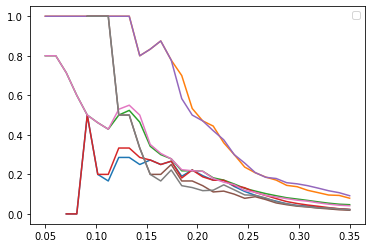

In [39]:
all_scores = pd.DataFrame(np.array(all_scores).T, index=thresholds)
all_scores.plot()
plt.legend([]);